# Deliverable 6.2: Landing MPC with All Four Subsystems

Merge the robust tube MPC for z-dimension with nominal MPC controllers for x, y, and roll subsystems.

In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import sys, os
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
import time
import numpy as np
from LandMPC.MPCLandControl import MPCLandControl
from src.rocket import Rocket
from src.pos_rocket_vis import *

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

# Rocket setup
Ts  = 1/20
rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
rocket.mass = 1.7  # Do not change!!!

# Visualization setup
vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1

In [3]:
# Landing maneuver: from (3, 2, 10, 30°) to (1, 0, 3, 0°)
sim_time = 15  # simulation length in seconds

# Initial state: at (3, 2, 10, 30°)
x0 = np.array([0, 0, 0,  # angular velocities (wx, wy, wz)
               0, 0, np.deg2rad(30),  # angles (alpha, beta, gamma/roll)
               0, 0, 0,  # linear velocities (vx, vy, vz)
               3, 2, 10])  # positions (x, y, z)

# Target state: (1, 0, 3, 0°)
x_ref = np.array([0.]*9 + [1., 0., 3.])  # Target: x=1, y=0, z=3

xs, us = rocket.trim(x_ref)
print("Linearization around landing target:")
print("x_ref = ", x_ref)
print("xs = ", xs)
print("us = ", us)

A, B = rocket.linearize(xs, us)

# MPC parameters
H = 2.0  # horizon time

# Create merged landing controller with all four subsystems
mpc = MPCLandControl().new_controller(rocket, Ts, H, x_ref=x_ref)
print("\nMerged landing MPC controller initialized")
print("  - MPCControl_x: nominal MPC for x-position")
print("  - MPCControl_y: nominal MPC for y-position")
print("  - MPCControl_z: robust tube MPC for z-position")
print("  - MPCControl_roll: nominal MPC for roll angle")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Linearization around landing target:
x_ref =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
xs =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3.]
us =  [ 0.          0.         56.66666667  0.        ]
Minimal robust invariant set computation converged after 38 iterations.
Iteration 1... not yet converged
Iteration 2... not yet converged
Iteration 3... not yet converged
Iteration 4... not yet converged
Iteration 5... not yet converged
Iteration 6... not yet converged
Iteration 7... not yet converged
Iteration 8... not yet converged
Iteration 9... not yet converged
Iteration 10... not yet converged
Iteration 11... not yet co

## Simulate Landing Maneuver

Simulating time 0.00

 State alpha violation: 0.262698 > 0.174533, 
 State alpha violation: 0.381699 > 0.174533, 
 State beta violation: -0.176125 < -0.174533, 
 State alpha violation: 0.478887 > 0.174533, 
 State beta violation: -0.230833 < -0.174533, 
 State alpha violation: 0.550223 > 0.174533, 
 State beta violation: -0.283659 < -0.174533, 
 State alpha violation: 0.592987 > 0.174533, 
 State beta violation: -0.332128 < -0.174533, 
 State alpha violation: 0.604395 > 0.174533, 
 State beta violation: -0.373229 < -0.174533, 
 State alpha violation: 0.581369 > 0.174533, 
 State beta violation: -0.404472 < -0.174533, 
 State alpha violation: 0.521843 > 0.174533, 
 State beta violation: -0.423938 < -0.174533, 
 State alpha violation: 0.425220 > 0.174533, 
 State beta violation: -0.429163 < -0.174533, 
 State alpha violation: 0.292119 > 0.174533, 
 State beta violation: -0.409653 < -0.174533, 
 State beta violation: -0.361736 < -0.174533, 
 State beta violation: -0.295964 < -0.174533, 
 

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=299, step=2), IntSlider(value=0…

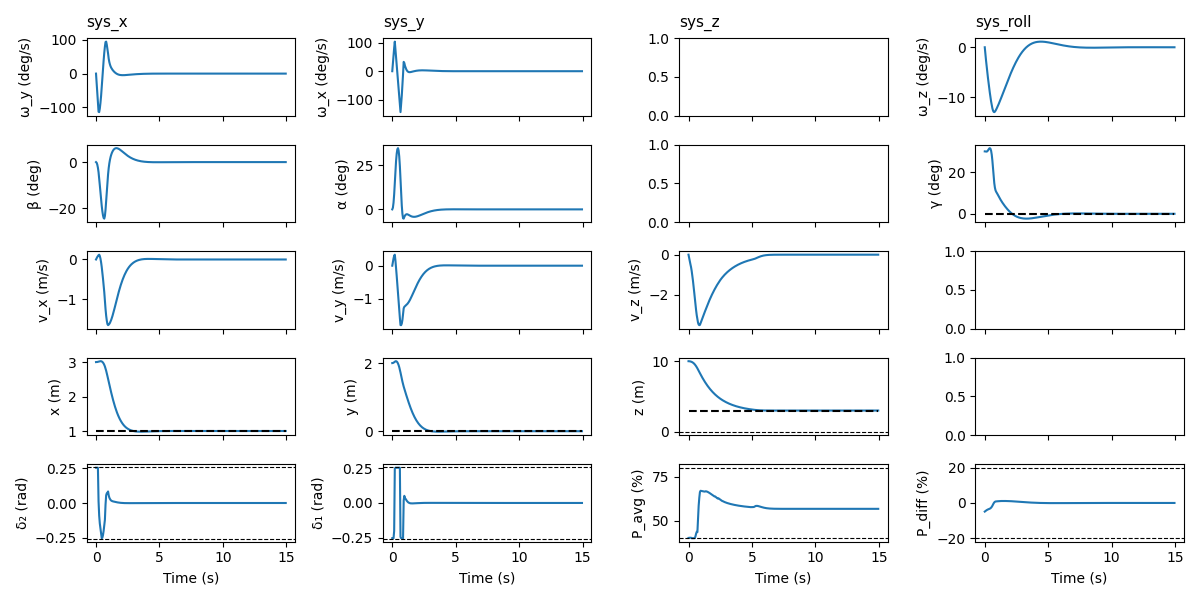

In [5]:
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol = rocket.simulate_land(mpc, sim_time, H, x0)
vis.animate(t_cl[:-1], x_cl[:,:-1], u_cl, T_ol=t_ol[...,:-1], X_ol=x_ol, U_ol=u_ol)
plot_static_states_inputs(t_cl[:-1], x_cl[:,:-1], u_cl, xs)

## Analysis

**Questions to answer:**
1. Does the rocket successfully land at the target position (1, 0, 3) with 0° roll?
2. How does the robust tube MPC for z-dimension perform compared to nominal MPC?
3. Are all constraints satisfied throughout the maneuver (especially z ≥ 0)?
4. What is the effect of the tightened constraints in the robust controller?